In [1]:
# Copyright (c) 2020 DEPEND Research Group at
# University of Illinois, Urbana Champaign (UIUC)
# This work is licensed under the terms of the MIT license.
# For a copy, see <https://opensource.org/licenses/MIT>.

In [2]:
!pip install palettable
!pip install nltk

In [3]:
# Import libraries
import math
import warnings
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats as st
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
%matplotlib inline
import seaborn as sns
import palettable
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Import parsers
%run ReportParsers.py

# Setup Seaborn visualization
np.random.seed(sum(map(ord, 'aesthetics')))
sns.set_style('ticks')
sns.set_context('paper', font_scale=2, rc={'lines.linewidth': 2.5})
sns.set_palette(palettable.colorbrewer.qualitative.Dark2_7.mpl_colors)

[nltk_data] Downloading package stopwords to /home/james/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/james/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
def format_figure(ax):
    ax.figure.tight_layout()
    ax.figure.subplots_adjust(right=0.75)  
    ax.figure.autofmt_xdate()

# Load disengagement datasets

In [5]:
DATASETS = [
    NissanRawDataParser(2015, "raw_csv_files/nissan_2015_totalmiles.csv", "raw_csv_files/nissan_2015_disengagements.csv"),
    NissanRawDataParser(2016, 'raw_csv_files/nissan_2016_totalmiles.csv', 'raw_csv_files/nissan_2016_disengagements.csv'),
    TeslaRawDataParser(2016, 'raw_csv_files/tesla_2016_totalmiles.csv', 'raw_csv_files/tesla_2016_disengagements.csv'),
    GMCruiseRawDataParser(2015, 'raw_csv_files/gmcruise_2015_totalmiles.csv', 'raw_csv_files/gmcruise_2015_disengagements.csv'),
    GMCruiseRawDataParser(2016, 'raw_csv_files/gmcruise_2016_totalmiles.csv', 'raw_csv_files/gmcruise_2016_disengagements.csv'),
    BoschRawDataParser(2015, 'raw_csv_files/bosch_2015_totalmiles.csv'),
    BoschRawDataParser(2016, 'raw_csv_files/bosch_2016_totalmiles.csv'),
    DelphiRawDataParser(2015, 'raw_csv_files/delphi_2015_totalmiles.csv', 'raw_csv_files/delphi_2015_disengagements.csv'),
    DelphiRawDataParser(2016, 'raw_csv_files/delphi_2016_totalmiles.csv', 'raw_csv_files/delphi_2016_disengagements.csv'),
    BenzRawDataParser(2016, 'raw_csv_files/benz_2016_disengagements.csv',None),
    BenzRawDataParser(2015, 'raw_csv_files/benz_2015_disengagements.csv','raw_csv_files/benz_2015_totalmiles.csv'),
    VolkswagenRawDataParser(2015, 'raw_csv_files/volkswagen_2015_totalmiles.csv','raw_csv_files/volkswagen_2015_disengagements.csv'),
    WaymoRawDataParser(2015, 'raw_csv_files/waymo_2015_totalmiles.csv', 'raw_csv_files/waymo_2015_disengagements.csv'),
    WaymoRawDataParser(2016, 'raw_csv_files/waymo_2016_totalmiles.csv', 'raw_csv_files/waymo_2016_disengagements.csv')
]

# Distributions of time between disengagment

In [6]:
# Collect data for manufacturers across years
tbf_data = {}
for data in DATASETS:
    if data.manufacturer not in tbf_data:
        tbf_data[data.manufacturer] = []
    tbf_data[data.manufacturer] = tbf_data[data.manufacturer] + sum([v for k,v in data.parseTBF().items()], [])

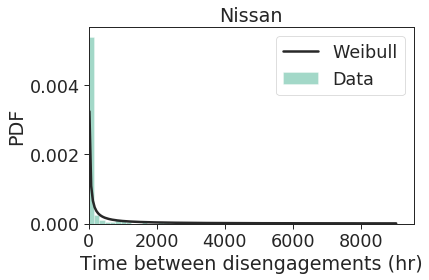

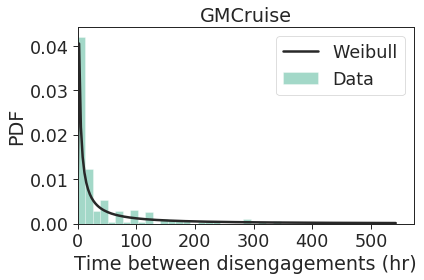

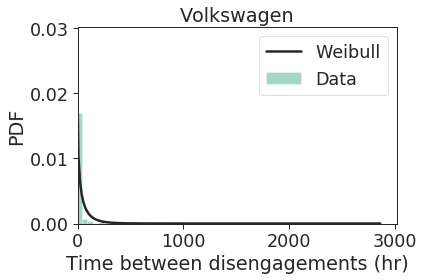

In [7]:
# Plot time between disengagements for manufacturers
distribution = st.exponweib

for mfr in tbf_data:
    if len(tbf_data[mfr]) > 0:
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            # Plot PDF
            ax = sns.distplot(tbf_data[mfr], fit=distribution, kde=False)
            ax.set_title(mfr)
            ax.set_ylabel('PDF')
            ax.set_xlabel('Time between disengagements (hr)')
            ax.set_xlim(left=0)    
        plt.legend(['Weibull', 'Data'])
        plt.tight_layout()
        plt.savefig('plots/tbd_%s_pdf.pdf'%(mfr))
        plt.show()

In [8]:
# Distributions to check
DISTRIBUTIONS = [        
    st.expon, st.exponweib, st.exponpow, st.erlang
]

for mfr in tbf_data:
    if len(tbf_data[mfr]) > 0:
        best_distribution = st.norm
        best_params = (0.0, 1.0)
        best_sse = np.inf
        for distribution in DISTRIBUTIONS:
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                params = distribution.fit(tbf_data[mfr])
                y, x = np.histogram(tbf_data[mfr], density=True)
                x = (x + np.roll(x, -1))[:-1] / 2.0
                k, p = st.kstest(tbf_data[mfr], lambda x: distribution.cdf(x, *params[:-2], loc=params[-2], scale=params[-1]))
                print('%s -> %s; params=%s, ks=%f, p=%f'%(mfr, distribution.name, params[:-2], k, p))


Nissan -> expon; params=(), ks=0.668677, p=0.000000
Nissan -> exponweib; params=(0.33242079161539656, 0.4393109875418444), ks=0.187862, p=0.000213
Nissan -> exponpow; params=(0.13851451691753341,), ks=0.288042, p=0.000000
Nissan -> erlang; params=(0.12654985660094709,), ks=0.234842, p=0.000001
GMCruise -> expon; params=(), ks=0.386439, p=0.000000
GMCruise -> exponweib; params=(1.763288131397056, 0.28241304916642224), ks=0.175032, p=0.000000
GMCruise -> exponpow; params=(0.591942576707372,), ks=0.441264, p=0.000000
GMCruise -> erlang; params=(0.052974710630726216,), ks=0.595358, p=0.000000
Volkswagen -> expon; params=(), ks=0.463867, p=0.000000
Volkswagen -> exponweib; params=(0.5990520044556867, 0.836124227479115), ks=0.381469, p=0.000000
Volkswagen -> exponpow; params=(0.2856993415511151,), ks=0.456026, p=0.000000
Volkswagen -> erlang; params=(1.4582762067917505,), ks=0.453593, p=0.000000


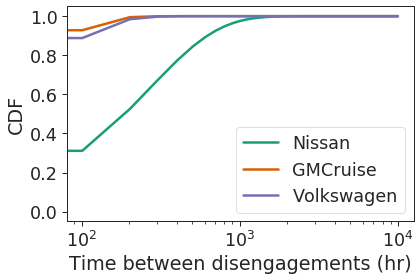

In [9]:
# Plot time between disengagements for manufacturers
f, ax = plt.subplots(1)
x = np.linspace(0, 10000, num=100)
for mfr in tbf_data:
    if len(tbf_data[mfr]) > 0:
        # Plot CDF
        a, l = st.expon.fit(tbf_data[mfr])
        ax.plot(x, st.expon.cdf(x, a, l), label=mfr)
han, lab = ax.get_legend_handles_labels()
ax.legend(han, lab)
ax.set_ylabel('CDF')
ax.set_xscale('log')
ax.set_xlabel('Time between disengagements (hr)')
plt.tight_layout()
plt.savefig('plots/tbd_cdf.pdf')
plt.show()

# Disengagements per mile per car

In [10]:
# Construct dataframe for plot
fpm_data = pd.DataFrame(columns=['time', 'Manufacturer', 'car', 'fpm', 'failures', 'miles'])

for data in DATASETS:
    fpm = data.parseFPM()
    for car in fpm:
        for t in fpm[car]:
            fpm_data = fpm_data.append({
                'time': mdates.date2num(dt.datetime.strptime(str(t), '%b-%Y')),
                'year': int(dt.datetime.strptime(str(t), '%b-%Y').strftime('%Y')),
                'time_string': t,
                'Manufacturer': data.manufacturer,
                'car': car,
                'fpm': float(fpm[car][t]['failures'])/fpm[car][t]['miles'],
                'failures': float(fpm[car][t]['failures']),
                'miles':fpm[car][t]['miles']}, ignore_index=True)
fpm_data = fpm_data.sort_values(['time','Manufacturer', 'car'])
fpm_data['miles_cumsum'] = fpm_data.groupby('Manufacturer')['miles'].transform(pd.Series.cumsum)
fpm_data['failures_cumsum'] = fpm_data.groupby('Manufacturer')['failures'].transform(pd.Series.cumsum)
fpm_data['fpm_cumsum'] = fpm_data['failures_cumsum']/fpm_data['miles_cumsum']

/home/james/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:1152: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


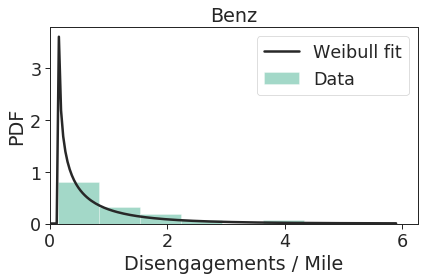

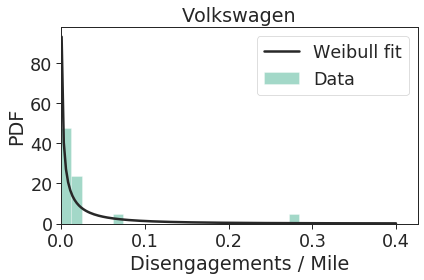

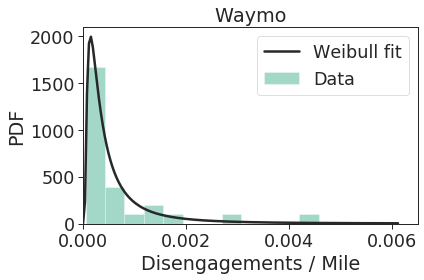

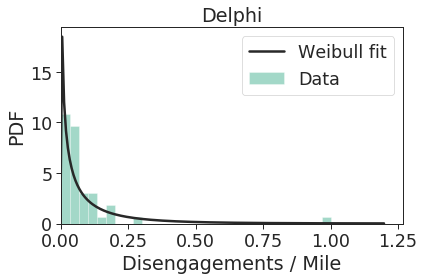

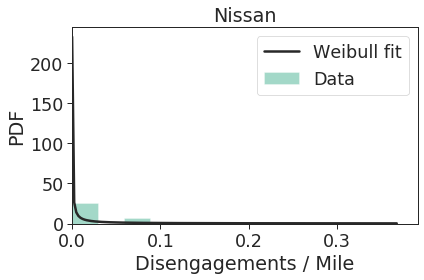

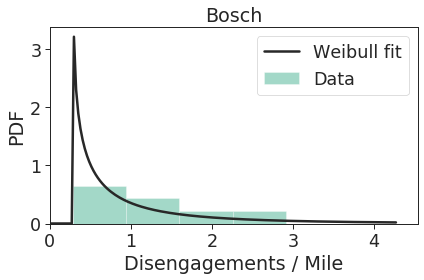

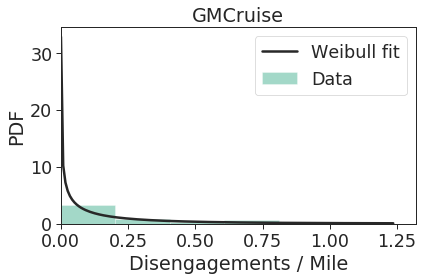

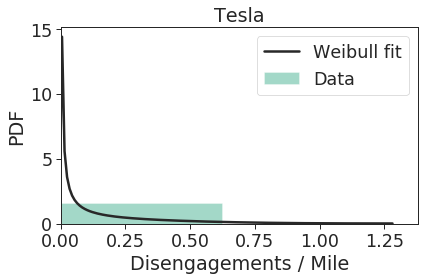

In [11]:
# Plot failure per mile for manufacturers
for mfr in fpm_data.Manufacturer.unique():
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        data = fpm_data.loc[fpm_data['Manufacturer'] == mfr]['fpm']
        ax = sns.distplot(data, fit=st.exponweib, kde=False)
        ax.set_ylabel('PDF')
        ax.set_xlabel('Disengagements / Mile')
        ax.set_xlim(left=0)
        ax.set_title(mfr)
    plt.legend(['Weibull fit', 'Data'])
    plt.tight_layout()
    plt.savefig('plots/fpm_%s_pdf.pdf'%(mfr))    
    plt.show() 

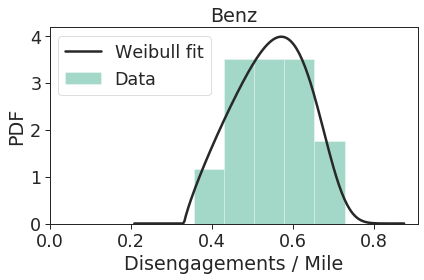

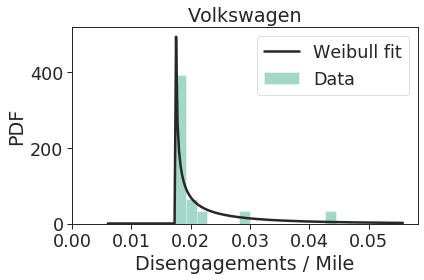

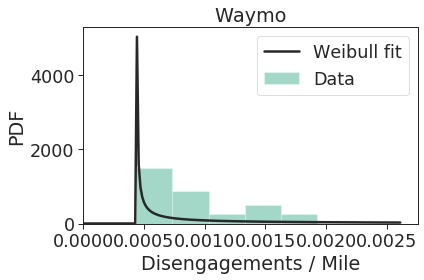

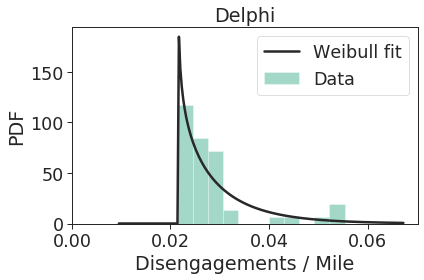

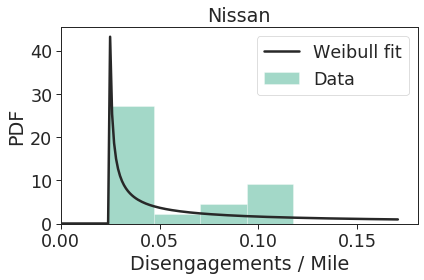

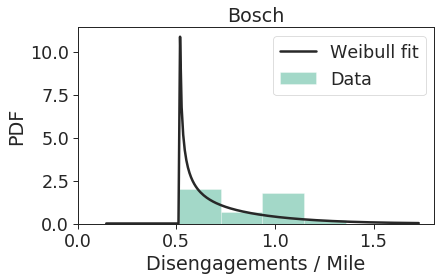

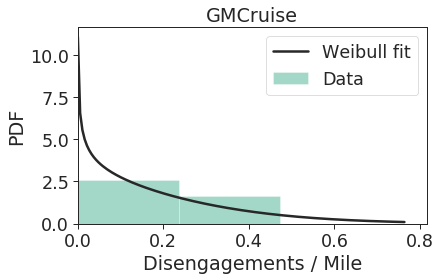

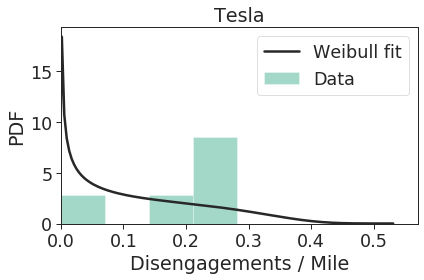

In [12]:
# Plot aggregate failure per mile for manufacturers
for mfr in fpm_data.Manufacturer.unique():
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        data = fpm_data.loc[fpm_data['Manufacturer'] == mfr]['fpm_cumsum']
        ax = sns.distplot(data, fit=st.exponweib, kde=False)
        ax.set_ylabel('PDF')
        ax.set_xlabel('Disengagements / Mile')
        ax.set_xlim(left=0)
        ax.set_title(mfr)
    plt.legend(['Weibull fit', 'Data'])
    plt.tight_layout()    
    plt.savefig('plots/afpm_%s_pdf.pdf'%(mfr))    
    plt.show()

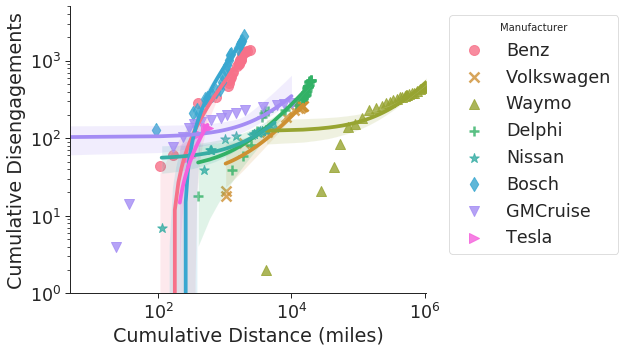

In [13]:
# Stability hypothesis
ax = sns.lmplot(x='miles_cumsum', y='failures_cumsum', hue='Manufacturer', data=fpm_data,
                truncate=True, markers=['o', 'x', '^', '+', '*', 'd', 'v', '>'],
                scatter_kws={"s": 100}, legend=False, aspect=16/9)
ax.set_axis_labels('Cumulative Distance (miles)', 'Cumulative Disengagements')
ax.ax.set_yscale('log')
ax.ax.set_xscale('log')
ax.ax.set_xlim([fpm_data['miles_cumsum'].min(), fpm_data['miles_cumsum'].max()])
ax.ax.set_ylim(bottom=1, top=5E3)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='Manufacturer')
plt.tight_layout()
plt.savefig('plots/failure_stability.pdf', bbox_inches="tight")
plt.show()

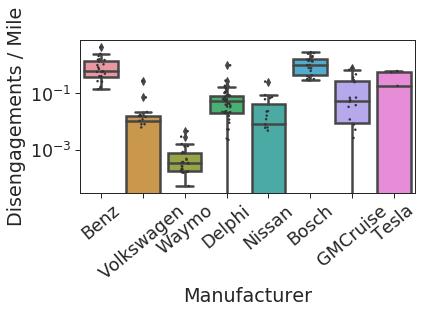

In [14]:
# Compare FPM across manufacturers
ax = sns.boxplot(x='Manufacturer', y='fpm', data=fpm_data)
sns.stripplot(x='Manufacturer', y='fpm', data=fpm_data, color='0.2', jitter=True, marker=".")
ax.set_yscale('log')
ax.set_ylabel('Disengagements / Mile')
plt.xticks(rotation=40)
plt.tight_layout()
plt.savefig('plots/fpm_comparison.pdf', bbox_inches="tight")
plt.show()

/home/james/anaconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


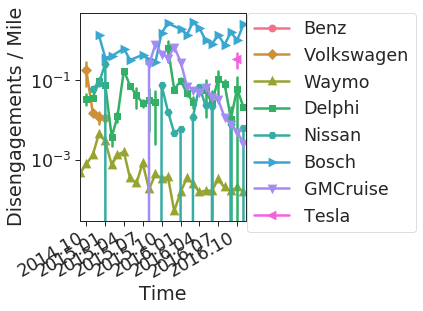

In [15]:
# Plot failures per mile for each manufacturer
ax = sns.tsplot(data=fpm_data, err_style='ci_bars', time="time", value="fpm", unit="car", condition="Manufacturer",
                marker='D')
ax.set_ylabel('Disengagements / Mile')
ax.set_xlabel('Time')
ax.set_yscale('log')
ax.axes.set_xlim(left=fpm_data['time'].min(), right=fpm_data['time'].max()+1E1)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m'))
ax.figure.autofmt_xdate()

markers=iter(['o', 'D', '^', 's', 'H', '>', 'v', '<'])
for l in ax.lines:
    if l.get_marker() == 'D':
        l.set_marker(next(markers))
        l.set_markeredgewidth(3)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.) 
plt.tight_layout()
ax.figure.autofmt_xdate()
plt.savefig('plots/fpm_time.pdf', bbox_inches="tight")
plt.show()

/home/james/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  # Remove the CWD from sys.path while we load stuff.


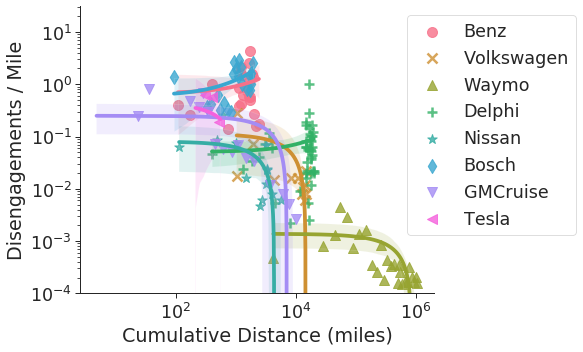

In [16]:
# Local FPM with time/more miles driven
ax = sns.lmplot(x='miles_cumsum', y='fpm', hue='Manufacturer', data=fpm_data,
                truncate=True, markers=['o', 'x', '^', '+', '*', 'd', 'v', '<'],
                scatter_kws={"s": 100}, legend=False, aspect=16/10)
ax.ax.set_xlabel('Cumulative Distance (miles)')
ax.ax.set_ylabel('Disengagements / Mile')
ax.ax.set_yscale('log')
ax.ax.set_xscale('log')
ax.ax.set_ylim(bottom=1E-4)
ax.ax.set_xlim(left=0)
plt.legend(bbox_to_anchor=(0.9,1), loc="upper left")
plt.tight_layout()
plt.savefig('plots/fpm_mile.pdf', bbox_inches="tight")
plt.show()

/home/james/anaconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


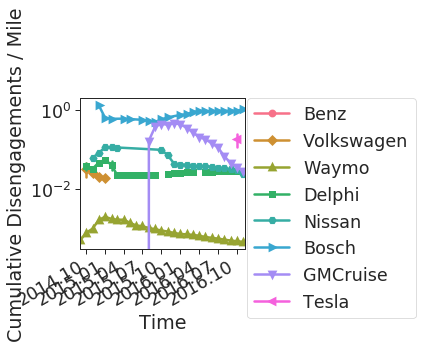

/home/james/anaconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


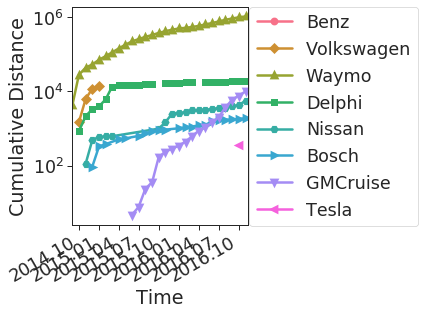

In [17]:
# Plot failures per mile for each manufacturer
ax = sns.tsplot(data=fpm_data, err_style='ci_bars', time="time", value="fpm_cumsum", unit="car", condition="Manufacturer", marker='D')
ax.set_ylabel('Cumulative Disengagements / Mile')
ax.set_xlabel('Time')
ax.set_yscale('log')
ax.axes.set_xlim([fpm_data['time'].min(), fpm_data['time'].max()+1E1])
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m'))
ax.figure.autofmt_xdate()

markers=iter(['o', 'D', '^', 's', 'H', '>', 'v', '<'])
for l in ax.lines:
    if l.get_marker() == 'D':
        l.set_marker(next(markers))
        l.set_markeredgewidth(3)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.) 
plt.tight_layout()
ax.figure.autofmt_xdate()
plt.savefig('plots/afpm_time.pdf', bbox_inches="tight")
plt.show()

ax = sns.tsplot(data=fpm_data, err_style=None, time="time", value="miles_cumsum", unit="car", condition="Manufacturer", marker='D')
ax.set_ylabel('Cumulative Distance')
ax.set_xlabel('Time')
ax.set_yscale('log')
ax.axes.set_xlim([fpm_data['time'].min(), fpm_data['time'].max()+1E1])
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m'))
ax.figure.autofmt_xdate()

markers=iter(['o', 'D', '^', 's', 'H', '>', 'v', '<'])
for l in ax.lines:
    if l.get_marker() == 'D':
        l.set_marker(next(markers))
        l.set_markeredgewidth(3)
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
ax.figure.autofmt_xdate()
plt.savefig('plots/amiles_time.pdf', bbox_inches="tight")
plt.show()

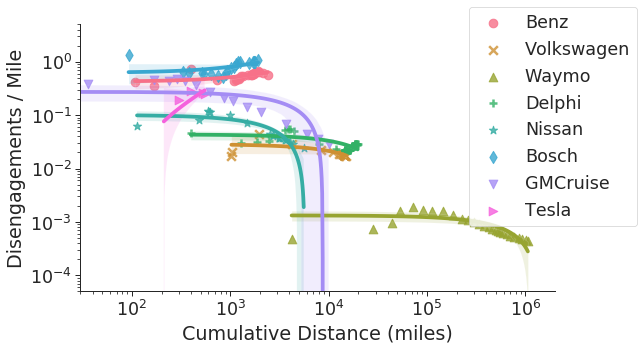

In [18]:
# Global FPM with time/more miles driven
ax = sns.lmplot(x='miles_cumsum', y='fpm_cumsum', hue='Manufacturer', data=fpm_data,
                truncate=True, markers=['o', 'x', '^', '+', '*', 'd', 'v', '>'],
                scatter_kws={"s": 75}, legend=False, aspect=16/9)
ax.ax.set_xlabel('Cumulative Distance (miles)')
ax.ax.set_ylabel('Disengagements / Mile')
ax.ax.set_yscale('log')
ax.ax.set_xscale('log')
ax.ax.set_ylim(bottom=5E-5, top=5)
ax.ax.set_xlim(left=30)
plt.legend(bbox_to_anchor=(.8,1.1), loc="upper left")
plt.tight_layout()
plt.savefig('plots/afpm_amiles.pdf', bbox_inches="tight")
plt.show()

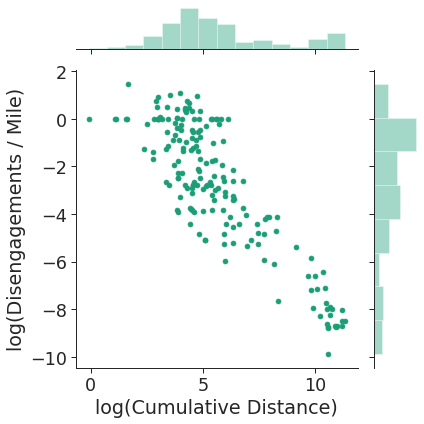

In [19]:
# Relationships (maybe this can show something insteresting)
(sns.jointplot(x=fpm_data['miles'].apply(lambda x: math.log(x)),
               y=fpm_data['fpm'].apply(lambda x: math.log(x) if x>0 else 0))
.set_axis_labels("log(Cumulative Distance)", "log(Disengagements / Mile)"))
plt.tight_layout()
plt.savefig('plots/fpm_miles_scatter.pdf')
plt.show()

/home/james/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/home/james/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


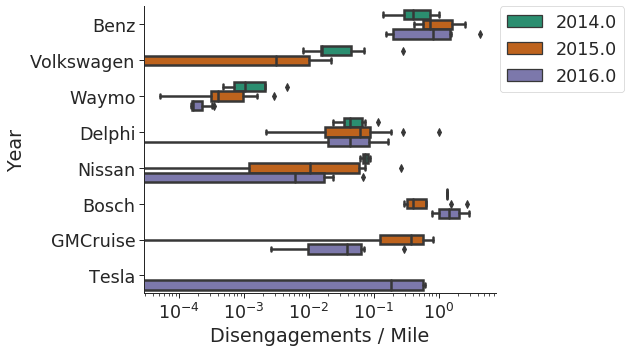

In [20]:
# Year vs Disengagements/Mile
ax = sns.factorplot(x="fpm", y="Manufacturer", hue="year", data=fpm_data,
                    kind="box", orient="h", size=5, aspect=16/9, legend=False)
ax.set_axis_labels('Disengagements / Mile', 'Year')
ax.ax.set_xscale('log')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
# format_figure(ax)
plt.tight_layout()
plt.savefig('plots/afpm_yearly.pdf', bbox_inches="tight")
plt.show()

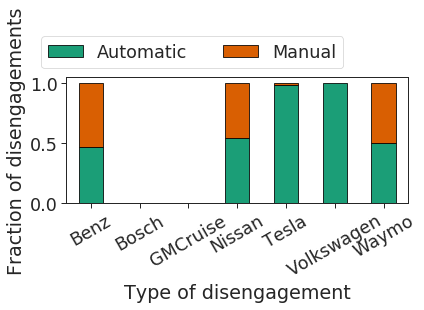

In [21]:
# Percentage of automatic, manual and planned tests
am_data = pd.DataFrame(columns=['Manufacturer', 'Automatic', 'Manual', 'Planned'])
for data in DATASETS:
    amp = data.parseManualAutomatic()
    if len(amp) > 0:
        am_data = am_data.append({
            'Manufacturer': data.manufacturer, 
            'Automatic': amp['auto'],
            'Manual': amp['manual'],
            'Planned': amp['planned']}, ignore_index=True)

df = am_data.groupby(['Manufacturer'])["Automatic", "Manual", "Planned"].sum()
ax = df.div(df.sum(axis=1), axis=0).plot(kind='bar', stacked=True, rot=1, edgecolor='k')
ax.set_ylabel("Fraction of disengagements")
ax.set_xlabel("Type of disengagement")
plt.legend(bbox_to_anchor=(-0.1,1), loc="lower left", ncol=3)
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig('plots/disengagement_types.pdf', bbox_inches="tight")
plt.show()

In [22]:
cat_mlp_P = 0
cat_mlp_A = 0
cat_mlp_M = 0

cat_mlc_P = 0
cat_mlc_A = 0
cat_mlc_M = 0

cat_sys_P = 0
cat_sys_A = 0
cat_sys_M = 0

cat_unk_P = 0
cat_unk_A = 0
cat_unk_M = 0

for data in DATASETS:
    #print (data.raw_disengagements[['fcat','Dtype']])
    for idx,dat in data.raw_disengagements.iterrows():
        if(dat['fcat'] == 'ml/design(c)'):
            if(dat['Dtype'] == "A" ):
                cat_mlc_A+=1
            elif(dat['Dtype'] == "M"):
                cat_mlc_M+=1
            elif(dat['Dtype'] == "P"):
                cat_mlc_P+=1
        elif(dat['fcat'] =='ml/design(p)'):
            if(dat['Dtype'] == "A" ):
                cat_mlp_A+=1
            elif(dat['Dtype'] == "M"):
                cat_mlp_M+=1
            elif(dat['Dtype'] == "P"):
                cat_mlp_P+=1            
        elif(dat['fcat'] =='system'):
            if(dat['Dtype'] == "A" ):
                cat_sys_A+=1
            elif(dat['Dtype'] == "M"):
                cat_sys_M+=1
            elif(dat['Dtype'] == "P"):
                cat_sys_P+=1
        elif(dat['fcat'] =='unknown'):
            if(dat['Dtype'] == "A" ):
                cat_unk_A+=1
            elif(dat['Dtype'] == "M"):
                cat_unk_M+=1
            elif(dat['Dtype'] == "P"):
                cat_unk_P+=1
cat_sum = cat_mlp_P + cat_mlp_A + cat_mlp_M + cat_mlc_P + cat_mlc_A + cat_mlc_M + cat_sys_P + cat_sys_A + cat_sys_M
cat_sum = cat_sum+ cat_unk_P + cat_unk_A + cat_unk_M

print(cat_mlp_P/cat_sum," ",cat_mlc_P/cat_sum," ",cat_sys_P/cat_sum," ",cat_unk_P/cat_sum)
print(cat_mlp_A/cat_sum," ",cat_mlc_A/cat_sum," ",cat_sys_A/cat_sum," ",cat_unk_A/cat_sum)
print(cat_mlp_M/cat_sum," ",cat_mlc_M/cat_sum," ",cat_sys_M/cat_sum," ",cat_unk_M/cat_sum)
    

0.0   0.0   0.0   0.0
0.1791907514450867   0.04431599229287091   0.1676300578034682   0.0
0.13198458574181118   0.04816955684007707   0.22447013487475914   0.20423892100192678


# Disengagements by category

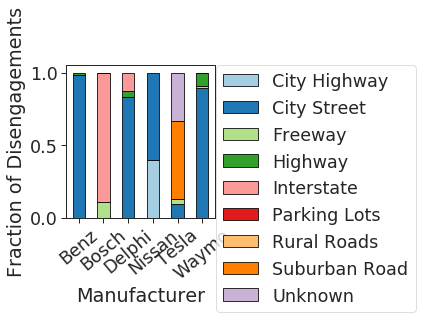

In [23]:
# Disengagments vs Road category
def reduce_road_categories(road):
    if road in ['City Street', 'Street', 'Arterial Road', 'Urban Street', 'Urban-Street']:
        return 'City Street'
    elif road in ['City And Highway', 'City Street Route 237', 'City Street/Hwy']:
        return 'City Highway'
    return road

road_type = pd.DataFrame(columns=['Manufacturer', 'Road Type', 'Number'])
for data in DATASETS:
    rt_dict = data.parseRoadTypes()
    for rt_key in rt_dict:
        road_type = road_type.append({
            'Manufacturer': data.manufacturer, 
            'Road Type': reduce_road_categories(rt_key.strip().title()),
            'Number': rt_dict[rt_key]}, ignore_index=True)
df = road_type.groupby(['Manufacturer','Road Type'])['Number'].sum().unstack().fillna(0)
ax = (df.div(df.sum(axis=1), axis=0)
     .plot(kind='bar', stacked=True, rot=1, color=palettable.colorbrewer.qualitative.Paired_10.mpl_colors, edgecolor='k'))
ax.set_ylabel("Fraction of Disengagements")
ax.set_xlabel("Manufacturer")
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=40)
plt.tight_layout()
plt.savefig('plots/disengagements_road_categories.pdf', bbox_inches="tight")
plt.show()

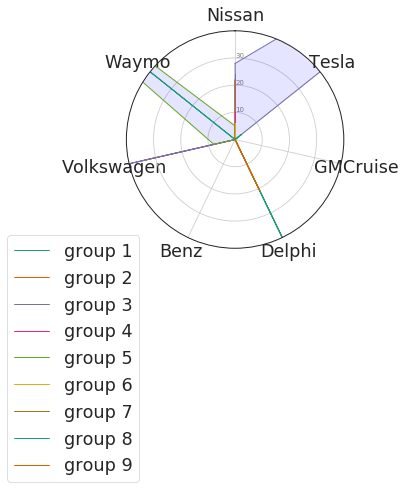

In [24]:
# Radar Char Failure Tag
# TODO: Parser not ready yet
from math import pi
failure_category_type = pd.DataFrame(columns = ["Manufacturer", "Reason"])
for d in DATASETS:
    counts = d.raw_disengagements['ftag'].value_counts()
    names = counts.index.tolist()
#     names.remove('')
    if len(names) < 1:
        pass
    for n in names:
        failure_category_type = failure_category_type.append({
            'Manufacturer': d.manufacturer, 
            'Reason': n,
            'Count': counts[n]}, ignore_index=True)
        
        
# ------- PART 1: Create background
df = failure_category_type.groupby(["Manufacturer", "Reason"]).sum()
groupedData = failure_category_type.groupby(['Manufacturer','Reason'])['Count'].sum()
colNames = failure_category_type["Reason"].unique().tolist()
newDF = []
manufacturers = failure_category_type["Manufacturer"].unique().tolist()
manufacturers.insert(0, "Manufacturer")
# newDF.append(manufacturers)
for n in colNames:
    if n== "":
        continue
    mData = [n,]
    for m in manufacturers:
        if m == "Manufacturer":
            continue
        try:
            mData.append(groupedData.loc[m][n])
        except:
            mData.append(0)
    newDF.append(mData)
df = pd.DataFrame(newDF, columns = manufacturers)
#print(df)
# ------- PART 1: Create background
 
# number of variable
categories=list(df)[1:]
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([10,20,30], ["10","20","30"], color="grey", size=7)
plt.ylim(0,40)

 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
for i in range(1,10):
    values=df.loc[i].drop('Manufacturer').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=1, linestyle='solid', label="group " + str(i))
    ax.fill(angles, values, 'b', alpha=0.1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))


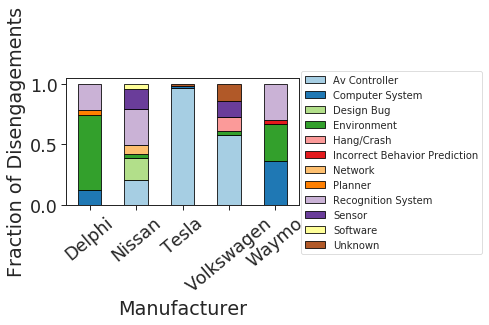

In [25]:
# Disengagements/mile by disengagement catergory
# TODO: Parser not ready yet
failure_category_type = pd.DataFrame(columns = ["Manufacturer", "Reason"])
for d in DATASETS:
    counts = d.raw_disengagements['ftag'].value_counts()
    names = counts.index.tolist()
    for n in names:
        if counts[n] >= 1 and n != '':
            failure_category_type = failure_category_type.append({
                'Manufacturer': d.manufacturer, 
                'Reason': n,
                'Count': counts[n]}, ignore_index=True)
failure_category_type['Reason'] = failure_category_type['Reason'].apply(lambda x: x.title())

df = failure_category_type.groupby(['Manufacturer','Reason'])['Count'].sum().unstack().fillna(0)
ax = (df.div(df.sum(axis=1), axis=0)
     .plot(kind='bar', stacked=True, rot=1, 
           color=palettable.colorbrewer.qualitative.Paired_12.mpl_colors, edgecolor='k'))
ax.set_ylabel("Fraction of Disengagements")
ax.set_xlabel("Manufacturer")
plt.xticks(rotation=40)
plt.legend(bbox_to_anchor=(1.01, 1.05), loc=2, borderaxespad=0.,fontsize = 10)
plt.tight_layout()
ax.figure.subplots_adjust(right=0.7)
plt.savefig('plots/disengagements_failure_reason_categories.pdf', bbox_inches="tight")
plt.show()

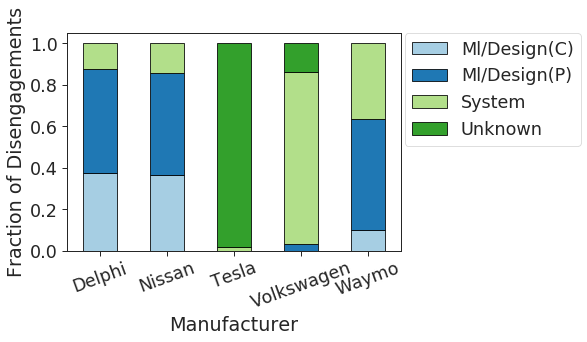

In [26]:
# Year vs Disengagements/Mile by Category --> Classify as system issues and all other issues
failure_category_type = pd.DataFrame(columns = ["Manufacturer", "Failure Type"])
for d in DATASETS:
    counts = d.raw_disengagements['fcat'].value_counts()
    names = counts.index.tolist()
    for n in names:
        if n !='' and counts[n] > 0:
            failure_category_type = failure_category_type.append({
                'Manufacturer': d.manufacturer, 
                'Failure Type': n.title(),
                'Count': counts[n]}, ignore_index=True)

df = failure_category_type.groupby(['Manufacturer','Failure Type'])['Count'].sum().unstack().fillna(0)

ax = (df.div(df.sum(axis=1), axis=0)
     .plot(kind='bar', stacked=True, rot=1, 
           color=palettable.colorbrewer.qualitative.Paired_10.mpl_colors, edgecolor='k'))
ax.set_ylabel("Fraction of Disengagements")
ax.set_xlabel("Manufacturer")
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.xticks(rotation=20)
plt.savefig('plots/disengagements_failure_categories.pdf', bbox_inches="tight")
plt.show()

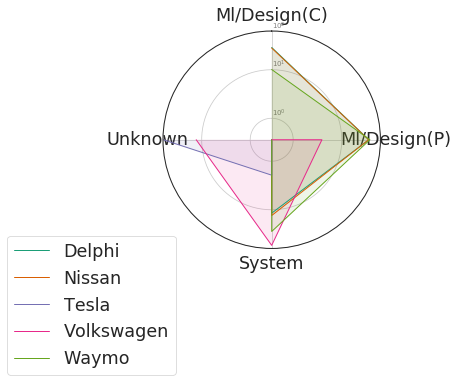

In [27]:
# Radar Char Failure Tag
# TODO: Parser not ready yet
from math import pi
failure_category_type = pd.DataFrame(columns = ["Manufacturer", "Failure Type"])
for d in DATASETS:
    counts = d.raw_disengagements['fcat'].value_counts()
    names = counts.index.tolist()
    for n in names:
        if n !='' and counts[n] > 0:
            failure_category_type = failure_category_type.append({
                'Manufacturer': d.manufacturer, 
                'Failure Type': n.title(),
                'Count': counts[n]}, ignore_index=True)
        
        
# ------- PART 1: Create background
df = failure_category_type.groupby(['Manufacturer','Failure Type'])['Count'].sum().unstack().fillna(0)
colNames = failure_category_type["Failure Type"].unique().tolist()
manufacturers = failure_category_type["Manufacturer"].unique().tolist()

# ------- PART 1: Create background
 
# number of variable
categories=list(df)
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([25,50,75,100], ["25","50","75","100"], color="grey", size=7)
plt.ylim(0,100)

 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1



for i in df.iterrows():
    values = i[1].values.tolist()
    # converting into percentages
    percentages = [x / sum(values)*100 for x in values] 
    
    ax.plot(angles[:-1], percentages, linewidth=1, linestyle='solid', label=i[0])
    ax.fill(angles[:-1], percentages, alpha=0.1)

# Add legend
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
ax.set_rscale('symlog')


# Reaction Times for Disengagements

In [28]:
# Get reaction time data
rt_time = pd.DataFrame(columns=['Manufacturer', 'Time', 'time_string', 'Reaction Time'])
for data in DATASETS:
    rt_dict = data.parseReactionTimes()
    for time in rt_dict:
        for rt in rt_dict[time]:
            rt_time = rt_time.append({
                'Manufacturer': data.manufacturer, 
                'Time': mdates.date2num(dt.datetime.strptime(str(time), '%b-%Y')),
                'time_string': time,
                'Reaction Time': rt}, ignore_index=True)

Nissan


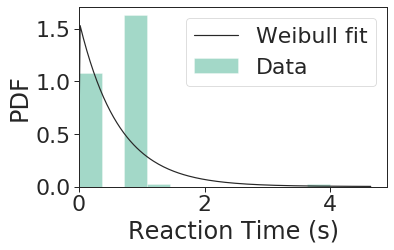

Tesla


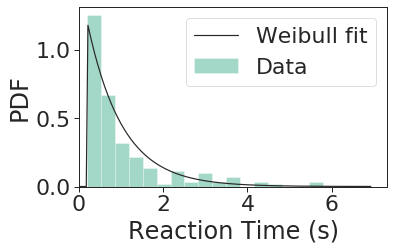

Delphi


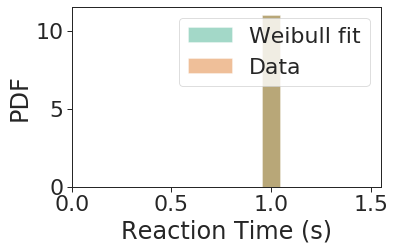

Benz


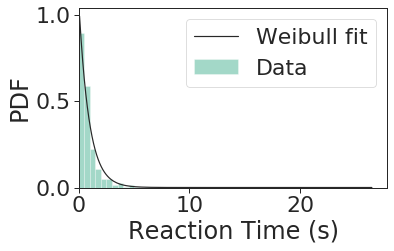

Volkswagen


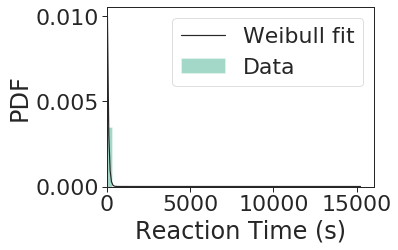

Waymo


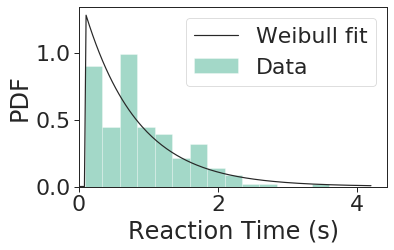

In [29]:
# Plot distributions of reaction times
with sns.plotting_context("paper", font_scale=2.5):
    for mfr in rt_time.Manufacturer.unique():
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            data = rt_time.loc[rt_time['Manufacturer'] == mfr]['Reaction Time'].dropna() 
            try:
                ax = sns.distplot(data, fit=st.expon, kde=False)
            except:
                ax = sns.distplot(data, kde=True)
            ax.set_ylabel('PDF')
            ax.set_xlabel('Reaction Time (s)')
            ax.set_xlim(left=0)
        plt.legend(['Weibull fit', 'Data'])
        plt.tight_layout()
        plt.savefig('plots/rt_%s_pdf.pdf'%(mfr), bbox_inches="tight")
        print(mfr)
        plt.show() 

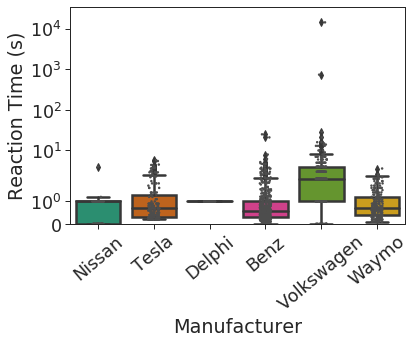

In [30]:
ax = sns.boxplot(x='Manufacturer', y='Reaction Time', data=rt_time)
sns.stripplot(x='Manufacturer', y='Reaction Time', data=rt_time, color='0.3', jitter=True, marker=".")
ax.set_yscale('symlog')
ax.set_ylabel('Reaction Time (s)')
ax.set_ylim(bottom=0)
plt.xticks(rotation=40)
plt.savefig('plots/rt_distribution.pdf', bbox_inches="tight")
plt.show()

# Accident Reports

In [31]:
!pip install geopandas folium

In [32]:
# Read in accident data
accident_data = pd.read_csv('raw_csv_files/incident_reports.tsv', sep='\t')
accident_data['Latitude'] = accident_data['Latitude'].apply(lambda x: float(x) if x != 'FAILED' else 0.)
accident_data['Longitude'] = accident_data['Longitude'].apply(lambda x: float(x) if x != 'FAILED' else 0.)

In [33]:
# Plot as markers
import folium
map = folium.Map(location=[37.77, -122.40], zoom_start=9, tiles="cartodbpositron")
for index, row in accident_data.iterrows():
    if row['Latitude'] != 'FAILED':
        folium.Marker([row['Latitude'], row['Longitude']], popup="Hello").add_to(map)
map

In [34]:
import folium
map = folium.Map(location=[37.77, -122.40], zoom_start=9, tiles="cartodbpositron")
folium.Marker([37.394071, -122.098242], popup="Hello").add_to(map)
folium.Marker([37.388744, -122.087684], popup="Hello").add_to(map)
map

In [35]:
# Plot heat map
from folium.plugins import HeatMap
map = folium.Map(location=[37.77, -122.40], zoom_start=9, tiles="cartodbpositron")
HeatMap(accident_data[['Latitude', 'Longitude']].as_matrix().tolist()).add_to(map)

map

/home/james/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


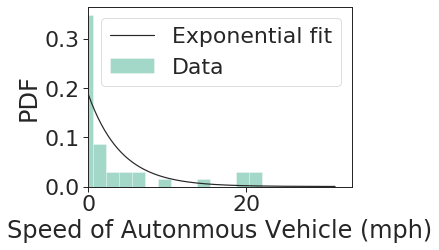

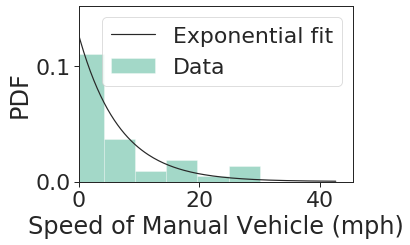

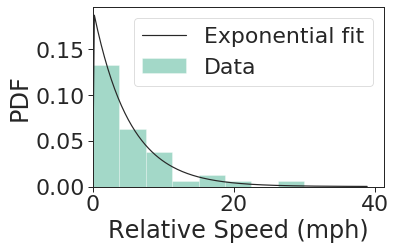

In [36]:
with sns.plotting_context("paper", font_scale=2.5):
    # Speeds at collision
    ax = sns.distplot(accident_data['Speed of AV'].fillna(-1), fit=st.expon, kde=False)
    ax.set_xlim(left=0)
    ax.set_xlabel('Speed of Autonmous Vehicle (mph)')
    ax.set_ylabel('PDF')
    plt.legend(['Exponential fit', 'Data'])
    plt.tight_layout()
    plt.savefig('plots/accident_av_speed.pdf')
    plt.show()
    
    ax = sns.distplot(accident_data['Speed of Manual'].fillna(-1), fit=st.expon, kde=False)
    ax.set_xlim(left=0)
    ax.set_xlabel('Speed of Manual Vehicle (mph)')
    ax.set_ylabel('PDF')
    plt.tight_layout()
    plt.legend(['Exponential fit', 'Data'])
    plt.savefig('plots/accident_manual_speed.pdf')
    plt.show()
    
    accident_data['Relative Speed'] = accident_data['Speed of AV'].fillna(-1) - accident_data['Speed of Manual'].fillna(-1)
    ax = sns.distplot(accident_data['Relative Speed'].apply(lambda x: x if x > 0 else -x), fit=st.expon, kde=False)
    ax.set_xlim(left=0)
    ax.set_xlabel('Relative Speed (mph)')
    ax.set_ylabel('PDF')
    plt.legend(['Exponential fit', 'Data'])
    plt.tight_layout()
    plt.savefig('plots/accident_relative_speed.pdf')
    plt.show()

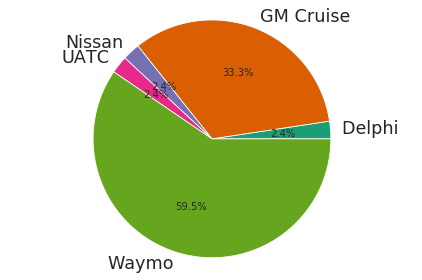

In [37]:
# Plot pie of manufacturers
df = accident_data.groupby(['Manufacturer'])['Date'].count()
ax = df.plot(kind='pie', y='Manufacturer', autopct='%1.1f%%', shadow=False, legend=False, colors=palettable.colorbrewer.qualitative.Dark2_5.mpl_colors)
ax.axis('equal')
ax.set_ylabel('')
plt.tight_layout()
plt.savefig('plots/accident_pie.pdf', bbox_inches="tight")
plt.show()

In [38]:
#Total Disengagements by Weather/Road Conditions (Nissan)
for data in DATASETS:
    if data.manufacturer=="Nissan":
        print(data.year,data.manufacturer)
        weatherData=data.parseWeatherWithFails()
        for category in weatherData:
            print(category,":",weatherData[category])
#NOTE: sunny + rainy + cloudy + night = overall
#    : dry + wet = overall

2015 Nissan
overall : 106
sunny : 53
cloudy : 35
rainy : 7
night : 11
dry : 88
wet : 18
2016 Nissan
overall : 29
sunny : 21
cloudy : 8
rainy : 0
night : 0
dry : 29
wet : 0
